# Tutorial 7: Spatial Stereo-CITE-seq (CRC)

This tutorial demonstrates cross-modal integration of the human colorectal cancer (CRC) spatial Stereo CITE-seq dataset (446,095 bins) using DePass, and identification of spatial domains within colon cancer tissues. The DePass employs a subgraph-based learning strategy, which enables efficient large-scale data processing by subgraph sampling without compromising data resolution.


### Preparation

In [ ]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('/home/jyx/DePass/')

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'

path = '../data/dataset_CRC_bin20'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '../data/dataset_CRC_bin20' already exists.



### Loading and Preprocessing

In [ ]:
adata_omics1 = sc.read_h5ad('../data/dataset_CRC_bin20/adata_RNA_006_bin20.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_CRC_bin20/adata_ADT_006_bin20.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='protein')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}

### Training the model

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='spatial', sub_graph_size=6e4,K_spatial=10,K_feature=30, device=device)
model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!


Computing METIS partitioning...
Done!



[Training]
Model training starts...


100%|██████████| 200/200 [2:14:59<00:00, 40.50s/it]  


Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh
adata.obsm['x2_enh'] = model.x2_enh

### Detect spatial domain 

Image saved to: ../data/dataset_CRC_bin20/DePass25.png


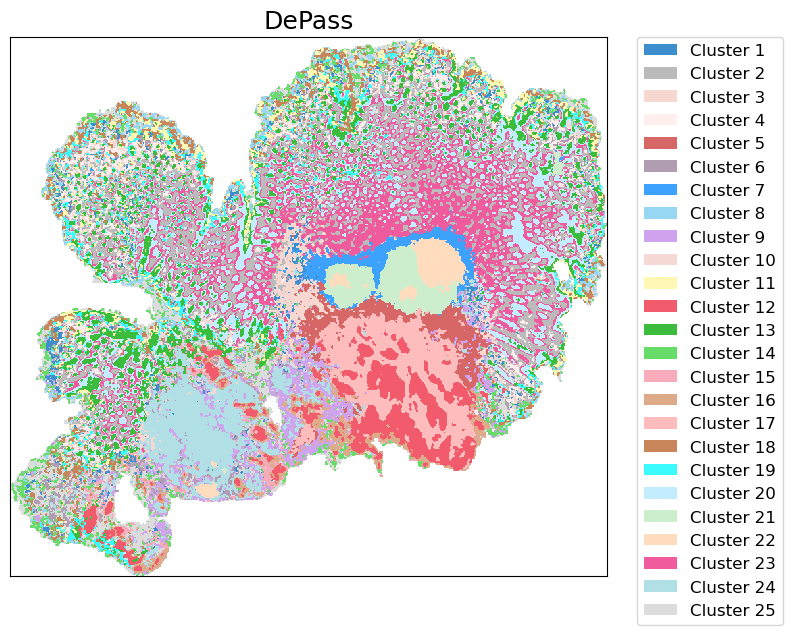

In [ ]:

from DePass.utils import *
clustering(adata=adata,n_clusters=25,key='DePass',add_key='DePass25',method='mclust', use_pca=True)

from DePass.analyze_utils import plot_superpixel

plot_superpixel(
    adata=adata,
    label_key='DePass25',
    save_path=path,
    save_name='DePass25',
    title="DePass",
    figscale=100,
    show=True
)